<center><span style="font-size:36px;">  🏈Expected Tackle Success Rate (ETSR) and Tackle Index🏈</span> </center>

***

### <font color='289C4E'  align>Table of contents<font><a class='anchor' id='top'></a>
- [Introduction](#1)
- [Data Summary](#2)
- [The ETSR Model](#3)
- [Applying ETSR to Player Data](#4)
- [How is this useful and innovative?](#5)


***

# Introduction <a class="anchor"  id="1"></a>

## Tackling Statistics
 Currently, the main metrics that are used to evaluate players and their ability to tackle are composed of raw counts and percentages. We can look at how many solo tackles, assists, and sacks that a player has and we can look at the percentage of tackle attempts they made that were successful. However, we believe that there is a bigger question that needs to be answered...*what makes a good tackle?*

#### By "good", we mean, what differentiates a successful tackle attempt from a missed tackle. 

### Project Goal:
To analyze historical tracking data and extract meaningful features to predict when a tackle attempt will be successful. We will then apply the model to players and determine their "Expected Tackle Success Rate (ETSR)", which we define as "the probability that a player will make a successful tackle when they attempt to tackle, based on their previous behavior."

We also introduce the "Tackle Index", which allows us to rank players based on their current track record related to tackling in addition to their ETSR. This accounts for consistent performance and number of games played.

***

# Data Summary <a class="anchor"  id="2"></a>
The data used for this analysis includes 2022 player tracking data, game data, play data, tackle data, and player statistics. To start, we combined this data to create a comprehensive table that could be used to look at every tackle attempt in the tracking data, tied to the ball carrier at the time and the tackler.


Example plays 
- https://nextgenstats.nfl.com/highlights/play/type/team/2022/1/playerId/2022102301/2468
- https://nextgenstats.nfl.com/highlights/play/type/team/2022/1/playerId/2022100902/730

We engineered additional features to supplement the data. Examples include:
- Standardized directional and positional data (to account for plays going in different directions)
- Force (Mass*Acceleration)
- Momentum (Mass * speed)
- Relative velocity: We looked at the speed of the ball carrier compared to the tackler
- Relative position: Distance between the ball carrier and tackler throughout the play
- Coefficient of Restitution COR= $\frac{(v_{2f} - v_{1f})}{(v_{2i} - v_{1i})}$ 


In order to look at what distinguishes a successful tackle from a missed tackle, we specifically excluded assists for the current model. Therefore, we looked at **9884** successful tackles and **2090** missed tackles. 

###  $\frac {9884}{11974}$ = 82.5%

#  The ETSR Model <a class="anchor"  id="3"></a>

Our model of Expected Tackle Success Rate (ETSR) blends the predictions from two classification models: **LGBMClassifier** and **RandomForestClassifier**.
The two models take the following features into account when assessing whether a tackle attempt will be successful:

- The orientation of the tackler
- The direction of the tackler
- The tackler's acceleration
- The ball carrier's speed
- The distance traveled by the ball carrier
- The speed of the tackler before the attempt
- The speed of the ball carrier before the attempt

By blending combinations of these features (i.e. the average speed of the ball carrier and the maximum speed of the tackler before the tackle attempt), the ETSR model predicts the tackle attempts success with **85.8% accuracy**.

The other metrics we used to assess the model's performance include F1 score, precision, recall, and Cohen's Kappa. (See appendix with resources on classification model metrics).


#  Applying ETSR to Player Data <a class="anchor"  id="4"></a>

We propose that coaches utilize the ETSR model for their players that need to be tracked for tackling ability. The ETSR score ranges from 0 to 1, with 1 being the highest expected success rate. However, this metric can be biased towards players with little data because if they only had one tackle attempt and it was successful, their score will be very close to 1. Therefore, we developed a **Tackle Index**  which factors in how many attempts a player actually made (proxy for their snap count).

## Tackle Index Calculation
The tackle index is relative to other players. It can be negative, zero , or positive depending on the previous tackles and missed tackles that the player has made. On the other hand, RTA always ranges from 0 to 1.

#### ${ETSR \times (Tackle Count + (.5 \times Assist Count)} -{[{(1-ETSR) \times Missed Tackle Count}+1]} $


In [1]:

from IPython.display import Image
import warnings
#!pip install eli5
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_columns", None)
#Image("/kaggle/input/shap-plots/LGBMshap.png")


In [2]:
#%run animate_vals.py

In [3]:

#Image("/kaggle/input/shap-plots/RFshap.png")


In [4]:

df_games=pd.read_csv('games.csv')
df_players=pd.read_csv('players.csv')
df_plays=pd.read_csv('plays.csv')
df_tackles=pd.read_csv('tackles.csv')
files=[]
for i in range(1,10):
    file='tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files) 



In [5]:
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180


In [6]:
df_tracking["o_standard"]=np.where(df_tracking["playDirection"] == "left", df_tracking["o"].apply(reverse_deg), df_tracking["o"])
        
df_tracking["dir_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["dir"].apply(reverse_deg), df_tracking["dir"])
        
df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
        
df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
    

In [7]:
def create_gameplayid(df):
    df['gameplayid']=df['gameId'].astype(str)+df['playId'].astype(str)
    return df

def create_index(df):
    df['index']=df['nflId'].astype(str)+df['gameplayid']
    return df
df_tracking=create_index(create_gameplayid(df_tracking))

df_plays=create_gameplayid(df_plays)
df_tackles=create_index(create_gameplayid(df_tackles))



In [8]:
#df_tackles[df_tackles['gameplayid']=='20220911083366']

In [9]:
#df_tracking[(df_tracking['gameplayid']=='20220911083366') & (df_tracking['displayName']=='Kristian Fulton')]

In [10]:
print('Distinct plays in tracking data: ', df_tracking['gameplayid'].nunique())
print('Distinct plays in play data: ', df_plays['gameplayid'].nunique())
print('Distinct plays in tackles data: ', df_tackles['gameplayid'].nunique())

Distinct plays in tracking data:  12486
Distinct plays in play data:  12486
Distinct plays in tackles data:  12025


In [11]:
df_tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,gameplayid,index
0,2022090800,101,42816,1,0,0,0,2022090800101,428162022090800101
1,2022090800,393,46232,1,0,0,0,2022090800393,462322022090800393
2,2022090800,486,40166,1,0,0,0,2022090800486,401662022090800486
3,2022090800,646,47939,1,0,0,0,2022090800646,479392022090800646
4,2022090800,818,40107,1,0,0,0,2022090800818,401072022090800818


In [25]:
def merge_clean_data(df_tracking, df_plays, df_tackles):
    df_tracking_plays_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=['gameplayid', 'gameId', 'playId'], right_on=['gameplayid', 'gameId', 'playId'], how='inner'), df_tackles, left_on=['gameplayid', 'gameId', 'playId', 'nflId'], right_on=['gameplayid', 'gameId', 'playId', 'nflId'], how='inner' )

  
    df_tackles_final=pd.merge(df_tracking_plays_final, df_tackles, left_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], right_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle','assist', 'pff_missedTackle'], how='left', suffixes=['_1', '_2'])
    df_tackles_final=df_tackles_final[((df_tackles_final['gameplayid'].isna()==False))]
    df_tackles_final['tackle_event']=np.where((df_tackles_final['tackle']==1) & (df_tackles_final['event']=='tackle'), 1,0)
    df_tackles_final['missed_tackle']=np.where((df_tackles_final['tackle']==0) & (df_tackles_final['pff_missedTackle']==1), 1, 0)
    df_tackles_final['index']=df_tackles_final['nflId'].astype(str)+df_tackles_final['gameplayid'].astype(str)+df_tackles_final['frameId'].astype(str)
    return df_tackles_final
df_tackles_final=merge_clean_data(df_tracking, df_plays, df_tackles)

In [26]:

print('Distinct plays in  final data: ', df_tackles_final['gameplayid'].nunique())
print('Distinct frames in  final data: ', df_tackles_final['index'].nunique())

Distinct plays in  final data:  12022
Distinct frames in  final data:  804123


In [27]:
def ballcarrier_df(df_players):
    df_ballcarrier_players=df_players.copy()
    df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
    
    df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
    df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
    df_ballcarrier=df_ballcarrier[['gameplayid', 'frameId',  'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']]
    df_ballcarrier.columns=['gameplayid', 'frameId',  'x_ballcarrier', 'y_ballcarrier', 's_ballcarrier',
                        'a_ballcarrier', 'dis_ballcarrier', 'o_ballcarrier',
       'dir_ball_carrier', 'event_ballcarrier', 'o_standard_ballcarrier', 'dir_standard_ballcarrier', 'x_standard_ballcarrier',
       'y_standard_ballcarrier','nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']
    return df_ballcarrier
    
df_ballcarrier=ballcarrier_df(df_players)


In [28]:
def full_merge(df_tackles_final):
    df_players_tackler=df_players.copy()
    df_players_tackler.columns=['nflId_tackler', 'tacklerHeight', 'tacklerWeight', 'tacklerDOB', 'tacklerCollege', 'tacklerPosition', 'tacklerDisplayName']
    df_tackles_final=pd.merge(df_tackles_final, df_players_tackler, left_on='nflId', right_on='nflId_tackler')
    df_full=pd.merge(df_tackles_final, df_ballcarrier, left_on=['gameplayid','ballCarrierDisplayName','frameId'], right_on=['gameplayid', 'ballCarrierDisplayName','frameId'])
    df_full.rename(columns={ 'x':'x_tackler','y': 'y_tackler', 's':'s_tackler', 'a':'a_tackler', 'dis':'dis_tackler',
       'o':'o_tackler', 'dir':'dir_tackler', 'event':'event_tackler', 'o_standard':'o_standard_tackler',
       'dir_standard':'dir_standard_tackler', 'x_standard':'x_standard_tackler', 'y_standard':'y_standard_tackler'}, inplace=True)
    return df_full
df_full=full_merge(df_tackles_final)


- In physics, there are two types of collisions: elastic and inelastic. An elastic collision results in objects moving apart at the same rate at which they collided. On the other hand, an inelastic collision results in objects staying stuck together. According to [The University of Arkansas ](https://phys.libretexts.org/Courses/Merrimack_College/Conservation_Laws_Newton's_Laws_and_Kinematics_version_2.0/08%3A_C8_Conservation_of_Energy-_Kinetic_and_Gravitational/8.05%3A_Relative_Velocity_and_the_Coefficient_of_Restitution) you can quantify how elastic a collision is with the coefficient of restitution (COR). Typically football tackles are classified as inelastic collisions, but we'd like to use the COR to quantify how inelastic a tackle is.



In [29]:
def create_force_features(df_full):
    df_full['force_ballcarrier']=df_full['ballCarrierWeight']*df_full['a_ballcarrier']
    df_full['force_tackler']=df_full['tacklerWeight']*df_full['a_tackler']
    df_full['momentum_ballcarrier']=df_full['ballCarrierWeight']*df_full['s_ballcarrier']
    df_full['momentum_tackler']=df_full['tacklerWeight']*df_full['s_tackler']
    #calculate distance between player tackling and player being tackled
    df_full['dis_ballcarrier_tackler']=np.sqrt(((df_full['x_standard_ballcarrier'] -df_full['x_standard_tackler'])**2)+((df_full['y_standard_ballcarrier'] -df_full['y_standard_tackler'])**2))
    return df_full
df_full=create_force_features(df_full)


In [30]:
import time

def minutes_to_seconds(minutes):
  return minutes * 60

def seconds_to_minutes(seconds):
  return seconds // 60
def convert_minutes_to_seconds(hours_minutes_and_seconds):
  hours, minutes, seconds = hours_minutes_and_seconds.split(':')
  return minutes_to_seconds(int(minutes)) + seconds_to_minutes(float(seconds))




In [31]:
import datetime 
from datetime import datetime

df_full['time']=df_full['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f' ))
df_full['time_adj']=df_full['time'].apply(lambda x: x.time())
df_full['time_seconds']=df_full['time_adj'].apply(lambda x: convert_minutes_to_seconds(str(x)))


In [32]:

df_full['time_elapsed']=df_full.groupby(['gameplayid', 'frameId'])['time_seconds'].diff()


In [33]:
df_full.sort_values(by=['gameplayid', 'frameId'], inplace=True)


In [34]:

df_full['relative_direction']=df_full['dir_standard_tackler']-df_full['dir_standard_ballcarrier']
df_full['relative_o']=df_full['o_standard_tackler']-df_full['o_standard_ballcarrier']
df_full['playNullifiedByPenalty'].replace({'Y':1, 'N':0}, inplace=True)

In [35]:
df_groupplay=df_full.groupby(by=['gameplayid', 'displayName'])['dis_ballcarrier_tackler'].min().reset_index()
df_groupplay['tackleframe']=1
df_full=pd.merge(df_groupplay, df_full, left_on=['gameplayid', 'displayName', 'dis_ballcarrier_tackler'], right_on=['gameplayid','displayName', 'dis_ballcarrier_tackler'], how='right')
df_full['tackle_frame_final']=np.where((df_full['tackleframe']==1), 1, 0)
df_full['prior_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(1)
df_full['next_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(-1)
df_full['prior_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(1)
df_full['next_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(-1)


In [81]:
def group_by_play(df_full):
    df_full_grouped=df_full.groupby(by=['gameplayid',  'displayName', 'nflId_tackler', 'nflId_ballcarrier']).agg({'tackle_event':'max', 'assist':'max', 'missed_tackle':'max','playNullifiedByPenalty':'max', 'relative_o':'mean', 'relative_direction':'mean', 'time':['min', 'max'], 'time_seconds':['min', 'max'],'offenseFormation':pd.Series.mode,'tacklerPosition': pd.Series.mode, 'ballcarrierPosition':pd.Series.mode,'offenseFormation':'first',  'x_tackler':['min', 'max','mean'], 'y_tackler':['min', 'max','mean'],
                                  's_tackler':['first', 'last','min', 'max','mean'],'prior_speed_tackler':'max', 'next_speed_tackler':'max', 'prior_speed_ballcarrier':'max', 'next_speed_ballcarrier':'max', 'a_tackler':['min', 'max','mean'], 'dis_tackler':['min', 'max','mean'],
                                   'o_standard_tackler':['min', 'max','mean'],
                                  'dir_standard_tackler':['min', 'max','mean'], 'x_standard_tackler':['min', 'max','mean'], 'y_standard_tackler':['min', 'max','mean'],
                                  'quarter':['min', 'max','mean'], 'down':['min', 'max','mean'], 'yardsToGo':['min', 'max','mean'],
                                  'gameClock':['min', 'max'], 'preSnapHomeScore':['min', 'max','mean'], 'preSnapVisitorScore':['min', 'max','mean'],
                                   'absoluteYardlineNumber':['min', 'max','mean'], 'defendersInTheBox': ['min', 'max','mean'],
                                  'expectedPoints':['min', 'max','mean'],  'tacklerWeight': 'mean',
                                   's_ballcarrier':['first', 'last','min', 'max','mean'],
                                  'a_ballcarrier':['min', 'max','mean'], 'dis_ballcarrier': ['min', 'max','mean'],
                                  'o_standard_ballcarrier':['min', 'max','mean'],'dir_standard_ballcarrier':['min', 'max','mean'],
                                  'x_standard_ballcarrier':['min', 'max','mean'], 'y_standard_ballcarrier':['min', 'max','mean'], 'ballCarrierWeight':'mean', 'force_ballcarrier':['min', 'max','mean'],
                                  'force_tackler':['min', 'max','mean']}).reset_index()
    df_full_grouped.columns =df_full_grouped.columns.map('|'.join).str.strip('|')
    return df_full_grouped
df_full_grouped=group_by_play(df_full)



In [82]:
df_full_grouped=df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]

## Summary Statistics

In [83]:
print('Total plays: ', df_full_grouped['gameplayid'].nunique())
print('Total plays not nullified by penalty: ', df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]['gameplayid'].nunique())
print('Total row count: ', len(df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]))
print('Total missed tackles: ', len(df_full_grouped[((df_full_grouped['missed_tackle|max']==1))]['gameplayid']))
print('Total assists: ', len(df_full_grouped[((df_full_grouped['assist|max']==1))]['gameplayid']))
print('Total tackles: ', len(df_full_grouped[((df_full_grouped['tackle_event|max']==1))]['gameplayid']))

Total plays:  11700
Total plays not nullified by penalty:  11700
Total row count:  16988
Total missed tackles:  2001
Total assists:  5396
Total tackles:  7895


In [84]:
df_speed_subset=df_full[df_full['tackle_frame_final']==1][['gameplayid', 'displayName', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier']]

In [85]:
df_speed_subset.fillna(0, inplace=True)

In [86]:
df_playdescription = df_plays[['gameId', 'playId', 'playDescription', 'gameClock']].sort_values(by=['gameId',  'gameClock']).set_index('gameId')
df_gamedescription=df_playdescription.groupby(['gameId'])[['playDescription']].transform(lambda x: ','.join(x)).reset_index().drop_duplicates()
df_gamedescription.rename(columns={'playDescription':'gameDescription'}, inplace=True)

In [87]:
def create_position_variables(df_full_grouped):

    ballcarrier_position=pd.get_dummies(df_full_grouped[['gameplayid',  'displayName', 'ballcarrierPosition|mode']], columns=['ballcarrierPosition|mode'],drop_first=True).reset_index(drop=True)
    ballcarrier_position.columns=['gameplayid', 'displayName', 'QB_ballcarrier', 'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier']
    tackler_position=pd.get_dummies(df_full_grouped[['gameplayid','displayName', 'tacklerPosition|mode']], columns=['tacklerPosition|mode'],drop_first=True).reset_index(drop=True)
    tackler_position.columns=['gameplayid', 'displayName', 'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS']
    offense_formation=pd.get_dummies(df_full_grouped[['gameplayid', 'displayName','offenseFormation|first']], columns=['offenseFormation|first'], drop_first=True).reset_index(drop=True)
    df_merge=pd.merge(df_full_grouped,ballcarrier_position, on=['gameplayid', 'displayName'] )
    df_merge=pd.merge(df_merge,tackler_position, on=['gameplayid', 'displayName'])
    df_merge=pd.merge(df_merge, offense_formation, on=['gameplayid', 'displayName'])
    
    
    return df_merge
df_full_grouped=create_position_variables(df_full_grouped)

In [88]:
def create_diff_range(df_final):
    df_final['difference_speed']=df_final['s_tackler|max']-df_final['s_ballcarrier|max']
    df_final['difference_a']=df_final['a_tackler|max']-df_final['a_ballcarrier|max']
    df_final['difference_orientation']=df_final['o_standard_tackler|max']-df_final['o_standard_ballcarrier|max']
    df_final['tackler_x_range']=df_final['x_standard_tackler|max']-df_final['x_standard_tackler|min']
    df_final['tackler_y_range']=df_final['y_standard_tackler|max']-df_final['y_standard_tackler|min']
    df_final['tackler_s_range']=df_final['s_tackler|max']-df_final['s_tackler|min']
    df_final['tackler_a_range']=df_final['a_tackler|max']-df_final['a_tackler|min']
    df_final['o_range_tackler']=df_final['o_standard_tackler|max']-df_final['o_standard_tackler|min']
    df_final['dir_range_tackler']=df_final['dir_standard_tackler|max']-df_final['dir_standard_tackler|min']
    df_final['ballcarrier_x_range']=df_final['x_standard_ballcarrier|max']-df_final['x_standard_ballcarrier|min']
    df_final['ballcarrier_y_range']=df_final['y_standard_ballcarrier|max']-df_final['y_standard_ballcarrier|min']
    df_final['ballcarrier_s_range']=df_final['s_ballcarrier|max']-df_final['s_ballcarrier|min']
    df_final['ballcarrier_a_range']=df_final['a_ballcarrier|max']-df_final['a_ballcarrier|min']
    df_final['o_range_ballcarrier']=df_final['o_standard_ballcarrier|max']-df_final['o_standard_ballcarrier|min']
    df_final['dir_range_ballcarrier']=df_final['dir_standard_ballcarrier|max']-df_final['dir_standard_ballcarrier|min']
    df_final['next_speed_diff']= (df_final['next_speed_tackler|max']-df_final['next_speed_ballcarrier|max'])
    df_final['prior_speed_diff']=(df_final['prior_speed_tackler|max']-df_final['prior_speed_ballcarrier|max'])
    df_final['COR']=np.where(df_final['tackle_event|max']==1, (df_final['next_speed_diff']).astype(float)/(df_final['prior_speed_diff']+1).astype(float),0 )
    df_final['COR'].replace([float('inf'), float('-inf')], 0, inplace=True)

    return df_final
df_final=create_diff_range(df_full_grouped)

In [89]:


df_successful_tackles=df_final[df_final['tackle_event|max']==1]
df_successful_tackles['COR'].describe()


count    7.895000e+03
mean     1.020076e+00
std      4.007294e+13
min     -2.251800e+15
25%      1.452991e-01
50%      6.183206e-01
75%      1.781250e+00
max      2.251800e+15
Name: COR, dtype: float64

In [90]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables=[]
negative_variables=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['tackle_event|max'])
        if corr >=.08 and corr<.9 and p<.05:
            positive_variables.append(col)
        if corr <=-.08  and corr>=-.9 and p<.05:
            negative_variables.append(col)
        

print(positive_variables)
print(negative_variables)

['a_tackler|min', 'a_tackler|mean', 'dir_standard_tackler|min', 'a_ballcarrier|min', 'a_ballcarrier|mean', 'o_standard_ballcarrier|min', 'o_standard_ballcarrier|mean', 'force_ballcarrier|min', 'force_ballcarrier|mean', 'force_tackler|min', 'force_tackler|mean', 'difference_speed', 'next_speed_diff', 'prior_speed_diff']
['assist|max', 'missed_tackle|max', 'relative_o|mean', 's_tackler|last', 'prior_speed_ballcarrier|max', 'next_speed_ballcarrier|max', 's_ballcarrier|last', 's_ballcarrier|min', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'tackler_y_range', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range']


In [91]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables2=[]
negative_variables2=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['missed_tackle|max'])
        if corr >=.08 and corr<.9 and p<.05:
            positive_variables2.append(col)
        if corr <=-.08  and corr>=-.9 and p<.05:
            negative_variables2.append(col)
        

print(positive_variables2)
print(negative_variables2)

['prior_speed_ballcarrier|max', 'next_speed_ballcarrier|max', 'a_tackler|max', 's_ballcarrier|last', 's_ballcarrier|max', 's_ballcarrier|mean', 'dis_ballcarrier|max', 'dis_ballcarrier|mean', 'x_standard_ballcarrier|max', 'force_tackler|max', 'tackler_x_range', 'tackler_s_range', 'tackler_a_range', 'o_range_tackler', 'dir_range_tackler', 'ballcarrier_x_range', 'ballcarrier_y_range', 'ballcarrier_s_range']
['tackle_event|max', 'assist|max', 's_tackler|min', 'a_tackler|min', 'dis_tackler|min', 'o_standard_tackler|min', 'o_standard_tackler|mean', 'dir_standard_tackler|min', 'o_standard_ballcarrier|mean', 'force_tackler|min']


In [92]:
set(positive_variables+negative_variables)
  

{'a_ballcarrier|mean',
 'a_ballcarrier|min',
 'a_tackler|mean',
 'a_tackler|min',
 'assist|max',
 'ballcarrier_x_range',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'dis_ballcarrier|max',
 'dis_ballcarrier|mean',
 'force_ballcarrier|mean',
 'force_ballcarrier|min',
 'force_tackler|mean',
 'force_tackler|min',
 'missed_tackle|max',
 'next_speed_ballcarrier|max',
 'next_speed_diff',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|last',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 's_ballcarrier|min',
 's_tackler|last',
 'tackler_y_range'}

In [93]:
final_cols=[
'a_ballcarrier|mean',
 'a_ballcarrier|min',
 'a_tackler|mean',
 'a_tackler|min',
 'ballcarrier_x_range',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'dis_ballcarrier|max',
 'dis_ballcarrier|mean',
 'force_ballcarrier|mean',
 'force_ballcarrier|min',
 'force_tackler|mean',
 'force_tackler|min',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 's_ballcarrier|min',
 'tackler_y_range'
]

In [94]:
# Outlier Analysis

iqr_factor = [5]
list=[]

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in final_cols:
    
        IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
        lower_lim = df_final[col].quantile(0.25) - factor*IQR
        upper_lim = df_final[col].quantile(0.75) + factor*IQR
    
        cond = df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].shape[0]
        
        if  cond > 0 :
            list.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\nTOTAL OUTLIERS FOR {factor} IQR : {count}')
    print('')
    

Outliers for 5 IQR :
-------------------------------------
a_ballcarrier|min              :  26
a_tackler|min                  :  27
ballcarrier_x_range            :  99
dis_ballcarrier|max            :  172
force_ballcarrier|min          :  20
force_tackler|min              :  32
s_ballcarrier|min              :  99

TOTAL OUTLIERS FOR 5 IQR : 475



In [51]:
"""
def drop_outliers(df_final, col):
    IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
    lower_lim = df_final[col].quantile(0.25) - (7*IQR)
    upper_lim = df_final[col].quantile(0.75) + (7*IQR)
    df_final.drop(df_final[df_final[col]>(upper_lim)].index, inplace=True)
    df_final.drop(df_final[df_final[col]<(lower_lim)].index, inplace=True)

for col in final_cols:
    drop_outliers(df_final,col)
    """

'\ndef drop_outliers(df_final, col):\n    IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)\n    lower_lim = df_final[col].quantile(0.25) - (7*IQR)\n    upper_lim = df_final[col].quantile(0.75) + (7*IQR)\n    df_final.drop(df_final[df_final[col]>(upper_lim)].index, inplace=True)\n    df_final.drop(df_final[df_final[col]<(lower_lim)].index, inplace=True)\n\nfor col in final_cols:\n    drop_outliers(df_final,col)\n    '

<Axes: title={'center': 'Correlation Heatmap of Features'}>

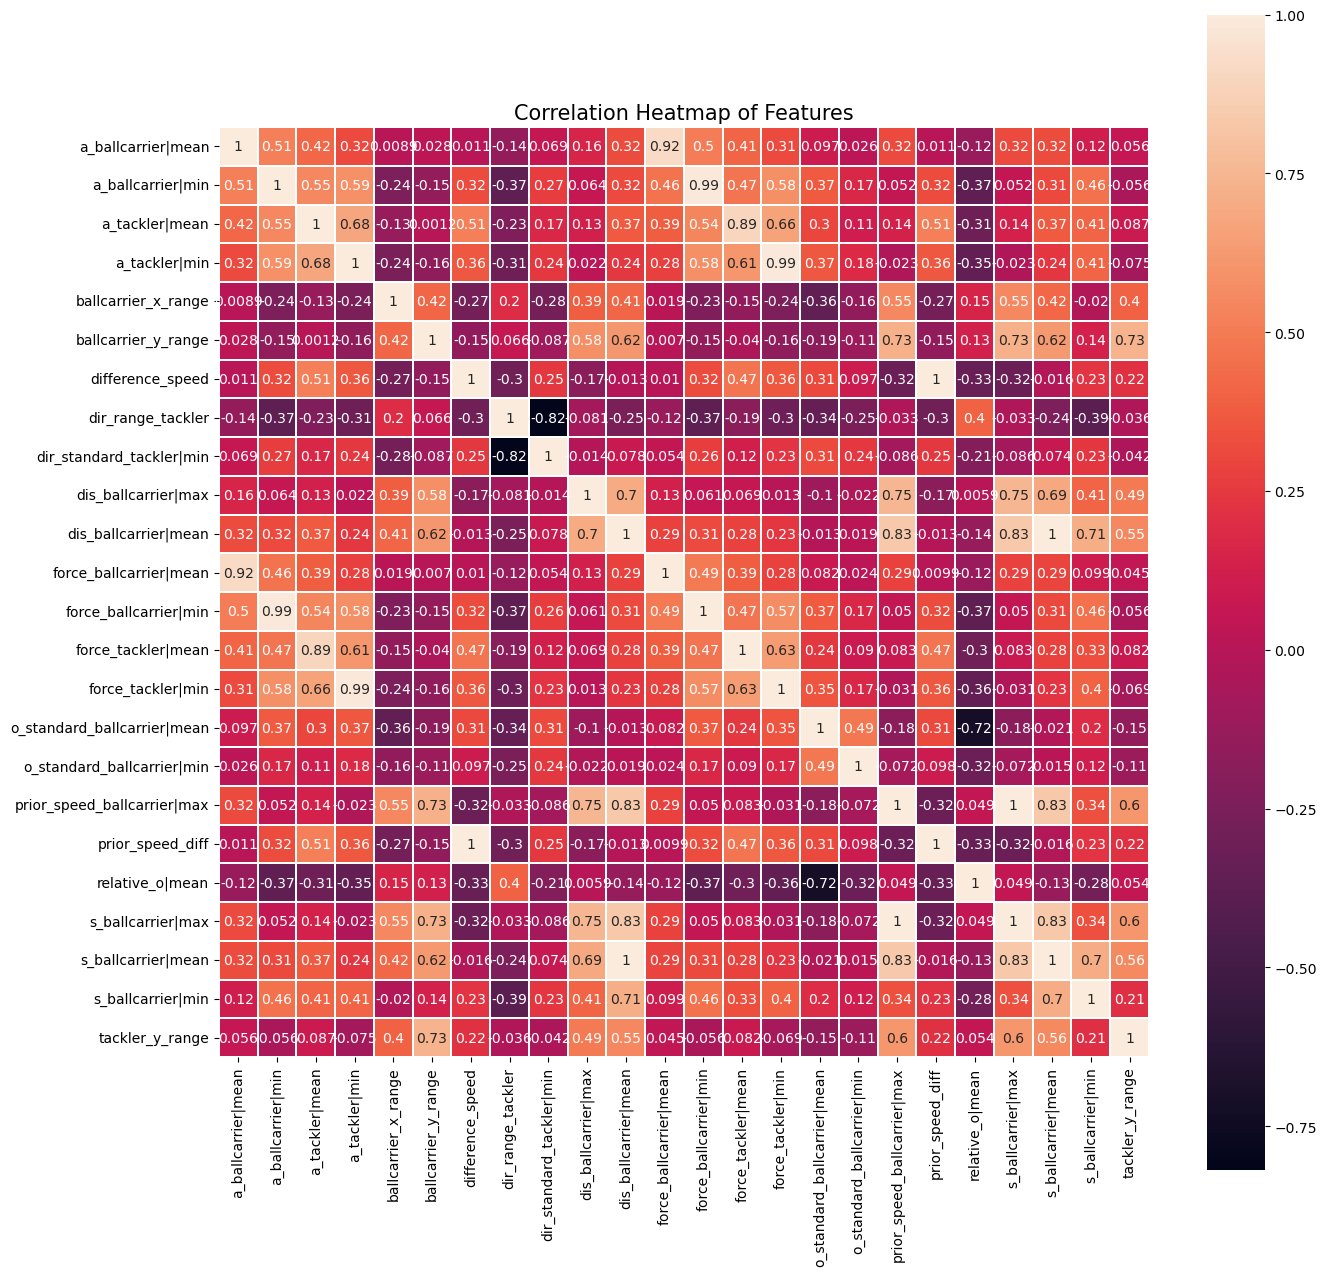

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(df_final_subset[final_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [98]:
df_set=df_final[['displayName','nflId_tackler','tackle_event|max','missed_tackle|max','assist|max',
'a_ballcarrier|mean',
 'a_ballcarrier|min',
 'a_tackler|mean',
 'a_tackler|min',
 'ballcarrier_x_range',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'dis_ballcarrier|max',
 'dis_ballcarrier|mean',
 'force_ballcarrier|mean',
 'force_ballcarrier|min',
 'force_tackler|mean',
 'force_tackler|min',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 's_ballcarrier|min',
 'tackler_y_range'

]].groupby(by=['displayName']).mean().reset_index()
df_set

df_set_gameplays=df_final[['displayName', 'gameplayid', 'nflId_tackler']].groupby(by=['displayName', 'nflId_tackler']).nunique().reset_index()
df_set_tackleassist=df_final[['displayName', 'tackle_event|max', 'missed_tackle|max', 'assist|max']].groupby(by='displayName').sum().reset_index()
df_set['gameplayid|nunique']=df_set_gameplays['gameplayid']
df_set[['tackle_count', 'missedTacklecount', 'assist_count']]=df_set_tackleassist[['tackle_event|max', 'missed_tackle|max', 'assist|max']]


In [99]:
df_final=df_final[(df_final['tackle_event|max']+ df_final['missed_tackle|max']==1)& (df_final['assist|max']==0)]
df_final.describe()

,nflId_tackler,nflId_ballcarrier,tackle_event|max,assist|max,missed_tackle|max,playNullifiedByPenalty|max,relative_o|mean,relative_direction|mean,time_seconds|min,time_seconds|max,x_tackler|min,x_tackler|max,x_tackler|mean,y_tackler|min,y_tackler|max,y_tackler|mean,s_tackler|first,s_tackler|last,s_tackler|min,s_tackler|max,s_tackler|mean,prior_speed_tackler|max,next_speed_tackler|max,prior_speed_ballcarrier|max,next_speed_ballcarrier|max,a_tackler|min,a_tackler|max,a_tackler|mean,dis_tackler|min,dis_tackler|max,dis_tackler|mean,o_standard_tackler|min,o_standard_tackler|max,o_standard_tackler|mean,dir_standard_tackler|min,dir_standard_tackler|max,dir_standard_tackler|mean,x_standard_tackler|min,x_standard_tackler|max,x_standard_tackler|mean,y_standard_tackler|min,y_standard_tackler|max,y_standard_tackler|mean,quarter|min,quarter|max,quarter|mean,down|min,down|max,down|mean,yardsToGo|min,yardsToGo|max,yardsToGo|mean,preSnapHomeScore|min,preSnapHomeScore|max,preSnapHomeScore|mean,preSnapVisitorScore|min,preSnapVisitorScore|max,preSnapVisitorScore|mean,absoluteYardlineNumber|min,absoluteYardlineNumber|max,absoluteYardlineNumber|mean,defendersInTheBox|min,defendersInTheBox|max,defendersInTheBox|mean,expectedPoints|min,expectedPoints|max,expectedPoints|mean,tacklerWeight|mean,s_ballcarrier|first,s_ballcarrier|last,s_ballcarrier|min,s_ballcarrier|max,s_ballcarrier|mean,a_ballcarrier|min,a_ballcarrier|max,a_ballcarrier|mean,dis_ballcarrier|min,dis_ballcarrier|max,dis_ballcarrier|mean,o_standard_ballcarrier|min,o_standard_ballcarrier|max,o_standard_ballcarrier|mean,dir_standard_ballcarrier|min,dir_standard_ballcarrier|max,dir_standard_ballcarrier|mean,x_standard_ballcarrier|min,x_standard_ballcarrier|max,x_standard_ballcarrier|mean,y_standard_ballcarrier|min,y_standard_ballcarrier|max,y_standard_ballcarrier|mean,ballCarrierWeight|mean,force_ballcarrier|min,force_ballcarrier|max,force_ballcarrier|mean,force_tackler|min,force_tackler|max,force_tackler|mean,QB_ballcarrier,RB_ballcarrier,TE_ballcarrier,WR_ballcarrier,tacklerPosition|mode_DB,tacklerPosition|mode_DE,tacklerPosition|mode_DT,tacklerPosition|mode_FS,tacklerPosition|mode_ILB,tacklerPosition|mode_MLB,tacklerPosition|mode_NT,tacklerPosition|mode_OLB,tacklerPosition|mode_SS,offenseFormation|first_I_FORM,offenseFormation|first_JUMBO,offenseFormation|first_PISTOL,offenseFormation|first_SHOTGUN,offenseFormation|first_SINGLEBACK,offenseFormation|first_WILDCAT,difference_speed,difference_a,difference_orientation,tackler_x_range,tackler_y_range,tackler_s_range,tackler_a_range,o_range_tackler,dir_range_tackler,ballcarrier_x_range,ballcarrier_y_range,ballcarrier_s_range,ballcarrier_a_range,o_range_ballcarrier,dir_range_ballcarrier,next_speed_diff,prior_speed_diff,COR
count,9854.000000,9854.000000,9854.000000,9854.0,9854.000000,9854.0,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,98

LDA: 0.840573 (0.005630)
[LightGBM] [Info] Number of positive: 6316, number of negative: 1567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5978
[LightGBM] [Info] Number of data points in the train set: 7883, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801218 -> initscore=1.393923
[LightGBM] [Info] Start training from score 1.393923
[LightGBM] [Info] Number of positive: 6316, number of negative: 1567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5978
[LightGBM] [Info] Number of data points in the train set: 7883, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801218 -> initscore=1.393923
[LightGBM] [Info] Start training from score 1.3939

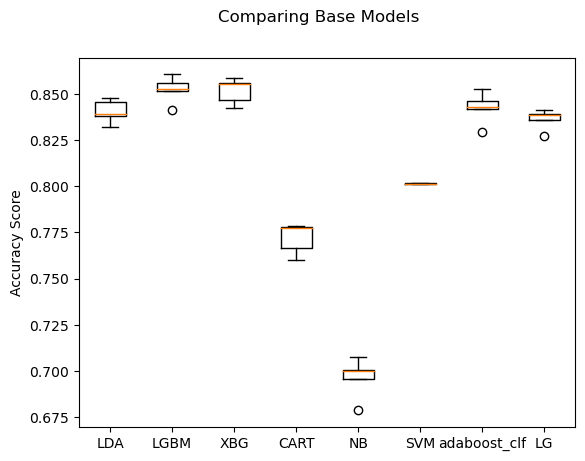

In [100]:
# Compare Algorithms
#!pip install xgboost
import pandas
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
X=df_final[final_cols
    
]

groups=df_final['displayName']
y=df_final['tackle_event|max']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
##models.append(('KNN', KNeighborsClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XBG', XGBClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('adaboost_clf', AdaBoostClassifier(
    estimator=weak_learner,
    algorithm="SAMME",
    random_state=42,
)))
models.append(('LG', LogisticRegression()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=5)
    
    cv_results = model_selection.cross_val_score(model, X, y,  cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparing Base Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy Score')
plt.show()


In [101]:
#!pip install optuna
import optuna  # pip install optuna
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    }
    gbm = LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [102]:

study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)


[I 2023-12-21 00:31:59,137] A new study created in memory with name: lightgbm


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-21 00:31:59,228] Trial 0 finished with value: 0.8011363636363636 and parameters: {'lambda_l1': 0.00010964446833279143, 'lambda_l2': 0.0006236005169774091, 'num_leaves': 28, 'feature_fraction': 0.4432678378309875, 'bagging_fraction': 0.8961920202465121, 'bagging_freq': 5, 'min_child_samples': 82, 'learning_rate': 0.0001252300072362579}. Best is trial 0 with value: 0.8011363636363636.
[I 2023-12-21 00:31:59,415] Trial 1 finished with value: 0.8011363636363636 and parameters: {'lambda_l1': 4.206042149428666, 'lambda_l2': 1.3971644232524315e-08, 'num_leaves': 188, 'feature_fraction': 0.8920483691914903, 'bagging_fraction': 0.6667843527582227, 'bagging_freq': 2, 'min_child_samples': 21, 'learning_rate': 0.0009532996518045932}. Best is trial 0 with value: 0.8011363636363636.
[I 2023-12-21 00:31:59,535] Trial 2 finished with value: 0.8011363636363636 and parameters: {'lambda_l1': 0.6644227687701885, 'lambda_l2': 0.00023656252607699688, 'num_leaves': 149, 'feature_fraction': 0.47766

In [103]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 0.0004945573163950415, 'lambda_l2': 0.0007973505248115672, 'num_leaves': 22, 'feature_fraction': 0.7654387780561228, 'bagging_fraction': 0.4460016390855718, 'bagging_freq': 5, 'min_child_samples': 58, 'learning_rate': 0.056231297862108794}


In [104]:
X_train, X_test, y_train, y_test=train_test_split(X, y, stratify=y)

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    gbm =XGBClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    prob = gbm.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(study_name="xgb", direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2023-12-21 00:32:03,772] A new study created in memory with name: xgb


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-12-21 00:32:04,206] Trial 0 finished with value: 0.8051948051948052 and parameters: {'max_depth': 9, 'learning_rate': 0.12396153517430837, 'n_estimators': 342, 'min_child_weight': 2, 'gamma': 0.00022816874562760992, 'subsample': 0.16214927788660471, 'colsample_bytree': 0.03246121924490855, 'reg_alpha': 1.6995035848548298e-07, 'reg_lambda': 0.011543311467292575}. Best is trial 0 with value: 0.8051948051948052.
[I 2023-12-21 00:32:04,270] Trial 1 finished with value: 0.8011363636363636 and parameters: {'max_depth': 1, 'learning_rate': 0.014917919844445678, 'n_estimators': 123, 'min_child_weight': 10, 'gamma': 0.0008091885446211109, 'subsample': 0.2426099407819193, 'colsample_bytree': 0.30663150197466305, 'reg_alpha': 0.00025226240080238066, 'reg_lambda': 2.1977597097509344e-07}. Best is trial 0 with value: 0.8051948051948052.
[I 2023-12-21 00:32:04,413] Trial 2 finished with value: 0.8271103896103896 and parameters: {'max_depth': 1, 'learning_rate': 0.049008525458888064, 'n_estim

In [105]:
print('Best parameters:', study.best_params)

Best parameters: {'max_depth': 6, 'learning_rate': 0.012859440240010091, 'n_estimators': 245, 'min_child_weight': 1, 'gamma': 1.9571612574147714e-07, 'subsample': 0.03440919664912688, 'colsample_bytree': 0.7967924569104154, 'reg_alpha': 0.00011046272821885607, 'reg_lambda': 3.0334068525980766e-08}


In [106]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
    'n_estimators': trial.suggest_int("n_estimators", 10, 200, log=True),
    'max_depth' : trial.suggest_int("max_depth", 2, 32),
    'min_samples_split' : trial.suggest_int("min_samples_split", 2, 10),
    'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10)
    }
    rf =RandomForestClassifier(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    prob = rf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(study_name="rf", direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2023-12-21 00:32:08,503] A new study created in memory with name: rf


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-12-21 00:32:11,701] Trial 0 finished with value: 0.841314935064935 and parameters: {'n_estimators': 163, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.841314935064935.
[I 2023-12-21 00:32:11,980] Trial 1 finished with value: 0.8299512987012987 and parameters: {'n_estimators': 17, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.841314935064935.
[I 2023-12-21 00:32:12,842] Trial 2 finished with value: 0.8380681818181818 and parameters: {'n_estimators': 43, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.841314935064935.
[I 2023-12-21 00:32:13,269] Trial 3 finished with value: 0.8392857142857143 and parameters: {'n_estimators': 21, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.841314935064935.
[I 2023-12-21 00:32:13,582] Trial 4 finished with value: 0.8348214285714286 and parameters: {'n_estim

In [107]:
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 118, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [110]:
lgbmparams= {'lambda_l1': 0.0004945573163950415, 'lambda_l2': 0.0007973505248115672, 'num_leaves': 22, 'feature_fraction': 0.7654387780561228, 'bagging_fraction': 0.4460016390855718, 'bagging_freq': 5, 'min_child_samples': 58, 'learning_rate': 0.056231297862108794,'class_weight':{0:1, 1:.5}}
xgbparams=  {'max_depth': 6, 'learning_rate': 0.012859440240010091, 'n_estimators': 245, 'min_child_weight': 1, 'gamma': 1.9571612574147714e-07, 'subsample': 0.03440919664912688, 'colsample_bytree': 0.7967924569104154, 'reg_alpha': 0.00011046272821885607, 'reg_lambda': 3.0334068525980766e-08}
rfparams= {'n_estimators': 118, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1}

Accuracy: 0.8011363636363636
F1: 0.44479495268138797
Precision: 0.4005681818181818
Recall: 0.5
Kappa: 0.0
AUC:  0.5


Text(0.5, 1.0, 'Confusion Matrix')

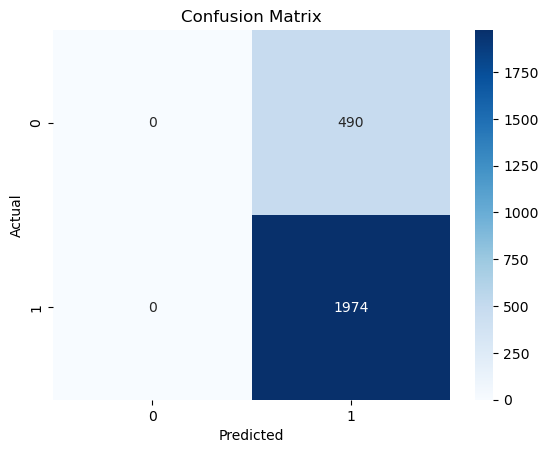

In [111]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score




dummy_clf = DummyClassifier(strategy="most_frequent")
X=df_final[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final['displayName']
y=df_final['tackle_event|max']

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.25, random_state=0)

dummy_clf.fit(X_train, y_train)



y_pred =  dummy_clf.predict(X_test)
y_proba=dummy_clf.predict_proba(X_test)
matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_test, y_pred,average='macro'))
print("Precision:", precision_score(y_test, y_pred,average='macro'))
print("Recall:", recall_score(y_test, y_pred,average='macro'))
print("Kappa:", cohen_kappa_score(y_test, y_pred))

print("AUC: ", roc_auc_score(y_test, y_pred))


sns.heatmap(matrix, annot=True,  cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from typing import Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

model =LGBMClassifier(**lgbmparams)
X=df_final[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final['displayName']
y=df_final['tackle_event|max']
kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array]:

    kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
    groups=df_final['displayName']
    
    
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X, y):

        X_train, y_train, X_test, y_test = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
       
        
        model.fit(
            X_train, y_train
        )


        


      
        actual_classes = np.append(actual_classes, y_test)
        

        predicted_classes = np.append(predicted_classes, model.predict(X_test))

        try:
            predicted_proba = np.append(predicted_proba, model.predict_proba(X_test), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(X_test), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    print("Accuracy:", accuracy_score(actual_classes, predicted_classes))

    print("F1:", f1_score(actual_classes, predicted_classes,average='macro'))
    print("Precision:", precision_score(actual_classes, predicted_classes,average='macro'))
    print("Recall:", recall_score(actual_classes, predicted_classes,average='macro'))
    print("Kappa:" , cohen_kappa_score(actual_classes, predicted_classes))
    print("AUC: ",  roc_auc_score(actual_classes, predicted_classes))
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()
    
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8433123604627563
F1: 0.6780509663226213
Precision: 0.8002965130831585
Recall: 0.6462206066672034
Kappa: 0.3728675356275988
AUC:  0.6462206066672033


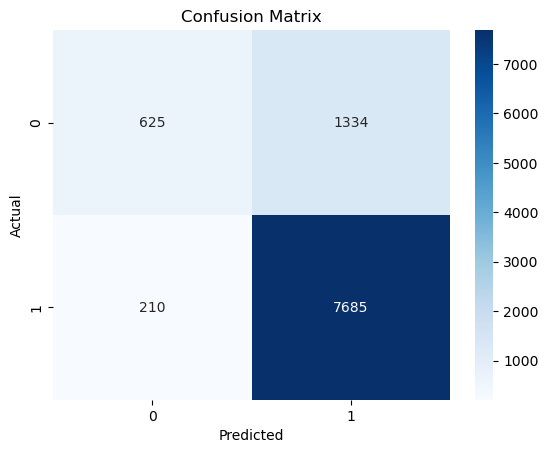

In [113]:
model=XGBClassifier(**xgbparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

Accuracy: 0.8409782829307896
F1: 0.6735476505773238
Precision: 0.7924109459078847
Recall: 0.6428449781638212
Kappa: 0.3639923859747658
AUC:  0.6428449781638212


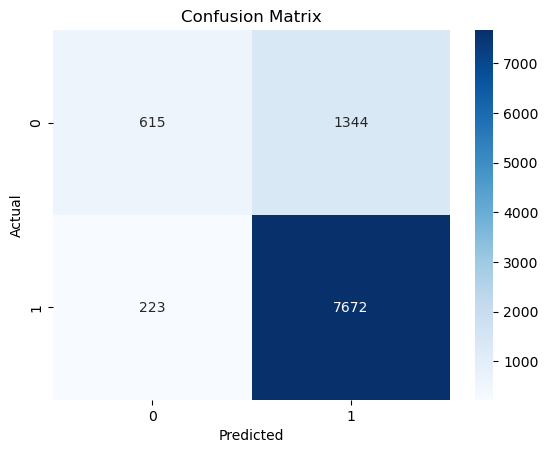

In [114]:
model=RandomForestClassifier(**rfparams)
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0,1])

In [115]:



df_train, df_test = train_test_split(df_final, stratify=df_final['tackle_event|max'], test_size=0.25, random_state=0)
import shap
# DF, based on which importance is checked
X_train=df_train[final_cols
    
]
X_test=df_test[final_cols]
y_train=df_train['tackle_event|max']
y_test=df_test['tackle_event|max']

model1=XGBClassifier(**xgbparams)
model1.fit(X_train, y_train)
probs1=model1.predict_proba(X_test)
model2=LGBMClassifier(**lgbmparams)
model2.fit(X_train, y_train)
probs2=model2.predict_proba(X_test)
model3=RandomForestClassifier(**rfparams)
model3.fit(X_train, y_train)
probs3=model3.predict_proba(X_test)






[LightGBM] [Warning] feature_fraction is set=0.7654387780561228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654387780561228
[LightGBM] [Warning] lambda_l1 is set=0.0004945573163950415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004945573163950415
[LightGBM] [Warning] lambda_l2 is set=0.0007973505248115672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007973505248115672
[LightGBM] [Warning] bagging_fraction is set=0.4460016390855718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4460016390855718
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7654387780561228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654387780561228
[LightGBM] [Warning] lambda_l1 is set=0.0004945573163950415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004945573163950415
[LightGBM] [Warning

In [ ]:
import shap


explainer2 = shap.Explainer(model2.predict, X_test)
shap_values2 = explainer2(X_test)




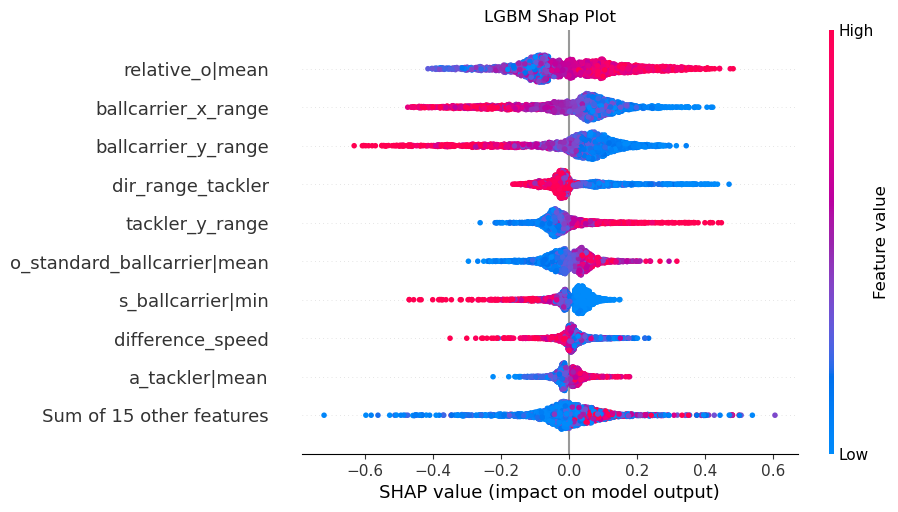

In [128]:
shap.plots.beeswarm(shap_values2, show=False)
plt.title('LGBM Shap Plot')
plt.savefig('LGBMshap.png', bbox_inches='tight')

In [129]:

explainer3 = shap.Explainer(model3.predict, X_test)
shap_values3 = explainer3(X_test)




Permutation explainer: 2465it [17:43,  2.30it/s]                          


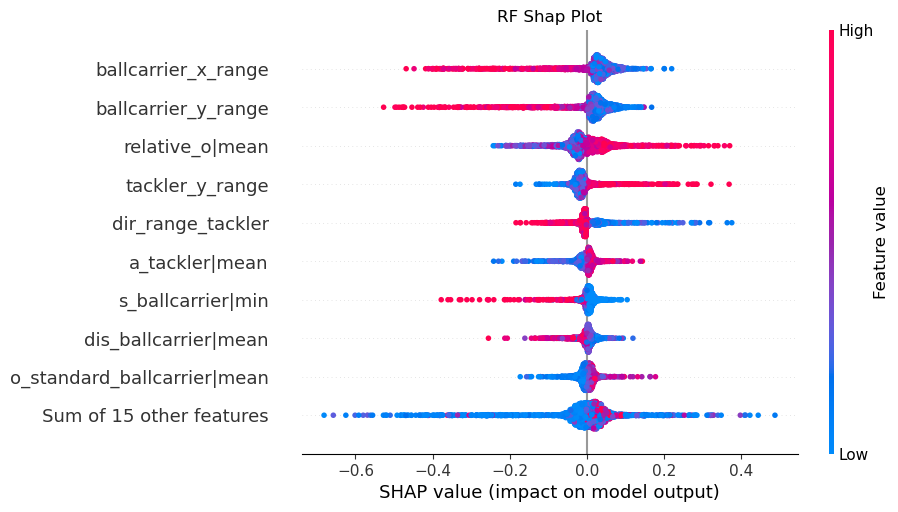

In [130]:

shap.plots.beeswarm(shap_values3, show=False)
plt.title('RF Shap Plot')
plt.savefig('RFshap.png', bbox_inches='tight')

In [116]:
df_test['prob_tackle1']=probs1[:, 1]
df_test['prob_miss1']=probs1[:, 0]

df_test['prob_tackle2']=probs2[:, 1]
df_test['prob_miss2']=probs2[:, 0]



df_test['prob_tackle3']=probs3[:, 1]
df_test['prob_miss3']=probs3[:, 0]


df_test['prob_tackle']=(df_test['prob_tackle1']+df_test['prob_tackle2']+df_test['prob_tackle3'])/3
df_test['prob_miss']=(df_test['prob_miss1']+df_test['prob_miss2']+df_test['prob_miss3'])/3

df_test['prediction']=np.where(df_test['prob_tackle']>.5, 1, 0)

df_test['y_test']=y_test

In [117]:
df_test[(df_test['prediction']!=df_test['y_test']) ].to_csv('missedpredictionsV2.csv')

Accuracy: 0.8636363636363636
F1: 0.7414141414141413
Precision: 0.825
Recall: 0.7054711246200608
Kappa: 0.48985507246376814
AUC:  0.7054711246200608


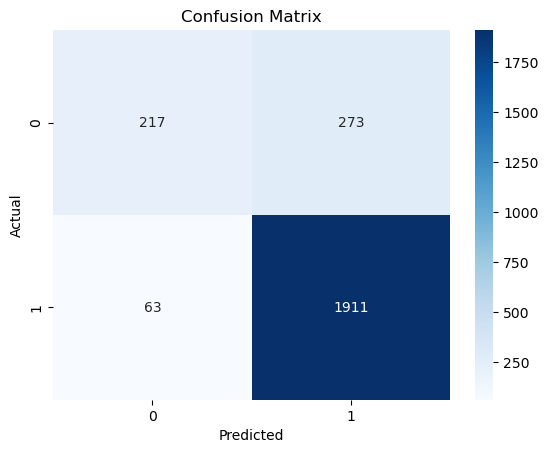

In [118]:
plot_confusion_matrix(df_test['y_test'], df_test['prediction'], [0,1])

In [119]:
X=df_set[final_cols]

probs1=model1.predict_proba(X)
probs2=model2.predict_proba(X)
probs3=model3.predict_proba(X)

df_set['prob_tackle1']=probs1[:, 1]
df_set['prob_miss1']=probs1[:, 0]


df_set['prob_tackle2']=probs2[:, 1]
df_set['prob_miss2']=probs2[:, 0]



df_set['prob_tackle3']=probs3[:, 1]
df_set['prob_miss3']=probs3[:, 0]


df_set['ETSR']=(df_set['prob_tackle1']+df_set['prob_tackle2']+df_set['prob_tackle3'])/3




[LightGBM] [Warning] feature_fraction is set=0.7654387780561228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654387780561228
[LightGBM] [Warning] lambda_l1 is set=0.0004945573163950415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004945573163950415
[LightGBM] [Warning] lambda_l2 is set=0.0007973505248115672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007973505248115672
[LightGBM] [Warning] bagging_fraction is set=0.4460016390855718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4460016390855718
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [120]:
df_set['tackle_index']=round((df_set['ETSR']*((df_set['tackle_count']*1)+(df_set['assist_count']*.5)))-((1-df_set['ETSR'])*(df_set['missedTacklecount']+1)), 2)

In [121]:

df_tackler_merge=pd.merge(df_players[['nflId', 'position', 'displayName']], df_set[['displayName', 'tackle_index', 'ETSR']], on='displayName')
df_tackles_grouped=df_tackles[['nflId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].groupby('nflId').sum() 
df_tackler_merge=pd.merge(df_tackler_merge, df_tackles_grouped, on='nflId')
df_tackler_merge.sort_values(by='tackle_index', ascending=False, inplace=True)
df_tackler_merge.reset_index(inplace=True)
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='tackle_index', ascending=False).head(10)

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
0,C.J. Mosley,ILB,44.18,0.748985,55,32,0,8
1,Bobby Okereke,ILB,43.69,0.818273,48,23,1,4
2,Rashaan Evans,ILB,43.48,0.759039,45,39,1,6
3,Foyesade Oluokun,ILB,43.32,0.700249,59,26,0,11
4,Roquan Smith,ILB,43.26,0.748386,50,32,0,7
5,Zaire Franklin,OLB,41.77,0.720681,55,28,0,12
6,Jordyn Brooks,ILB,40.96,0.734759,61,23,1,10
7,Nick Bolton,ILB,40.03,0.775253,46,23,0,2
8,Divine Deablo,OLB,35.89,0.739553,39,34,0,7
9,David Long,CB,35.88,0.748061,10,3,0,4


In [124]:
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='ETSR', ascending=False).head(10)

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
669,Arron Mosby,OLB,0.98,0.988117,1,0,0,0
641,Brandin Echols,CB,1.47,0.987654,2,1,0,0
601,Ambry Thomas,CB,1.95,0.983017,3,0,0,0
723,Percy Butler,FS,0.47,0.981772,0,1,0,0
672,Elijah Riley,CB,0.96,0.979036,1,0,0,0
674,Andrew Wingard,FS,0.94,0.969883,1,0,0,0
725,Troy Reeder,ILB,0.45,0.967993,0,1,0,0
675,Chris Banjo,FS,0.93,0.964686,1,0,0,0
581,Daviyon Nixon,DT,2.33,0.951030,1,3,0,0
295,Jonathan Bullard,DE,8.98,0.950137,8,3,0,0


<center><span style="font-size:36px;">  C.J. Mosley vs. Tony Adams</span> </center>

C.J.  Mosley is a top player from the NY Jets, but we wanted to look at his tackling stats compared to his teammate, Tony Adams. Mosley had **158 combined tackles and assists in 2022 and 131 in 2023**. Based on an analysis of his plays from 2022, his **ETSR is .74**, yet his tackle index is very high, putting him in the **top 10 players**.

On the other hand, Tony Adams has an **extremely high ETSR of .87 based on his 1 successful assist** that was recorded in our 2022 tracking data. His tackle index in 2022 was very low because he didn't play in many games, but based on the actions he took during that play, we expect his tackle success rate to be high, which is supported by his performance in 2023.


 > ## "We have all these guys that play at an All-Pro level, and it makes you want to be better," Adams said. "I am just going out there and trying to be better because of those guys. And one day, I have hopes to play at that level too." 
  [NewYorkJets.com](https://www.newyorkjets.com/news/jets-tony-adams-buffalo-bills-josh-allen)

#### Maybe he can...


<br></br>
 <center><img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/h0j0fahb2xtffumugal3.png" alt="CJ Mosley" width="300"/></center>
 <center>C.J. Mosley</center> 

<br></br>

<center>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  72   |   59  |   131     |
|2022   |NY Jets|  99   |   59  |  158      |

</center>
 <br></br> 

In [125]:
df_tackler_merge[df_tackler_merge['displayName']=='C.J. Mosley'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
0,C.J. Mosley,ILB,44.18,0.748985,55,32,0,8



<br></br><center> <img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/jtsntdaohmgigyike1hq.png" alt="Tony Adams" width="300"/></center>
## <center>Tony Adams</center>  
<br></br>

<center>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  45   |   22  |   67      |
|2022   |NY Jets|  10   |   7   |  17       |

</center>


In [126]:
(df_tackler_merge[df_tackler_merge['displayName']=='Tony Adams'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']])

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
738,Tony Adams,FS,0.31,0.874175,0,1,0,0



### Testing the ETSR and Tackle Index

 <center><b><i> A good test for the ETSR model would be to use his stats from his 2023 tracking data (or the second part of 2022) to determine if his tackle index increased and what happened to his ETSR. </i></b></center> 


# How is this useful and innovative? <a class="anchor"  id="5"></a>
We anticipate several use cases for our predictive model:
1. **Drafting new players** - based on tracking stats from prior tackle attempts, coaches and determine if a new player's ETSR makes them a good candidate for their team
2. **Adding to the PFF Player Grades** - We recommend adding a Tackle Grade in the PFF Player Grade cards. 
3. **Monitoring Player Progress** - If a player's ETSR starts to drop, it can mean that they are playing more inconsistently in terms of their tackling outcomes

In [ ]:
%run animate_vals.py

# Data Dictionary
## Tackles data
- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players (numeric)
- **tackle:** Indicator for whether the given player made a tackle on the play (binary)
- **assist:** Indicator for whether the given player made an assist tackle on the play (binary)
- **forcedFumble:** Indicator for whether the given player forced a fumble on the play (binary)
- **pff_missedTackle:** Provided by Pro Football Focus (PFF). Indicator for whether the given player missed a tackle on the play (binary)

## Tracking data

- **gameId:** Game identifier, unique (numeric)
- **playId:** Play identifier, not unique across games (numeric)
- **nflId:** Player identification number, unique across players. When value is NA, row corresponds to ball. (numeric)
- **displayName:** Player name (text)
- **frameId:** Frame identifier for each play, starting at 1 (numeric)
- **time:** Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
- **jerseyNumber:** Jersey number of player (numeric)
- **club:** Team abbrevation of corresponding player (text)
- **playDirection:** Direction that the offense is moving (left or right)
- **x:** Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
- **y:** Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
- **s:** Speed in yards/second (numeric)
- **a:** Speed in yards/second^2 (numeric)
- **dis:** Distance traveled from prior time point, in yards (numeric)
- **o:** Player orientation (deg), 0 - 360 degrees (numeric)
- **dir:** Angle of player motion (deg), 0 - 360 degrees (numeric)
- **event:** Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

# Resources Used


- https://francis-press.com/uploads/papers/ndkLZY5nQLH6nilaE0nfMi0dxkAogA90wpqUB2vK.pdf
- https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1079&context=cbbbpapers
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9459770/
- https://www.frontiersin.org/articles/10.3389/fspor.2021.669845/full
- https://entertainment.howstuffworks.com/physics-of-football.htm
- I used this notebook to standardize all of my directional data: 
https://www.kaggle.com/code/colinlagator/make-all-plays-left-right 